In [60]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier

from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process.kernels import _check_length_scale
from sklearn import svm, datasets
import seaborn as sns

from scipy.spatial.distance import pdist, cdist, squareform

data = datasets.make_classification(n_samples=150, n_classes=2,
                                        n_clusters_per_class=1,
                                        n_features=2, n_informative=2, n_redundant=0, n_repeated=0)
X = data[0]
y = data[1]
    
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (150, 2)
y shape: (150,)


In [61]:
class MySigmoidKernel(Kernel):
    
    def __init__(self, alpha_0=0.05, 
                 alpha_0_bounds=(1e-5, 1e5), 
                 sigma_0=20, 
                 sigma_0_bounds=(1e-5, 1e5)):
        self.alpha_0 = alpha_0
        self.alpha_0_bounds = alpha_0_bounds
        self.sigma_0 = sigma_0
        self.sigma_0_bounds = sigma_0_bounds

    @property
    def hyperparameter_scaling(self):
        return Hyperparameter("alpha_0", "numeric", self.alpha_0_bounds)
    
    @property
    def hyperparameter_shifting(self):
        return Hyperparameter("sigma_0", "numeric", self.sigma_0_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        if Y is None:
            K = np.tanh(self.sigma_0 + self.alpha_0 * np.inner(X, X))
        else:
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated when Y is None.")
            K = np.tanh(self.sigma_0 + self.alpha_0 * np.inner(X, Y))

        if eval_gradient:
            # gradient with respect to constant
            if not self.hyperparameter_shifting.fixed:
                sigma_gradient = np.empty((K.shape[0], K.shape[1], 1))
                sigma_gradient[...,0] = 1 - K**2
            else:
                sigma_gradient = np.empty((X.shape[0], X.shape[1], 0))
                    
            # gradient with respect to alpha
            if not self.hyperparameter_scaling.fixed:
                if Y is None:
                    alpha_gradient = np.empty((K.shape[0], K.shape[1], 1))
                    alpha_gradient[...,0] = np.inner(X,X) * (1-K**2)
                else: 
                    alpha_gradient = np.inner(X,Y) * (1-K**2)
            else: 
                alpha_gradient = np.empty((K.shape[0], K.shape[1], 0))
            
            K_gradient = np.dstack((alpha_gradient, sigma_gradient))

            print("K shape", K.shape)
            print("K_gradient shape", K_gradient.shape)
            
            return K, K_gradient

        else:
            return K

    def diag(self, X):
        return np.apply_along_axis(self, 1, X).ravel()

    def is_stationary(self):
        return False

    def __repr__(self):
        return "{0}(sigma_0={1:.3g})".format(
            self.__class__.__name__, self.sigma_0)

In [62]:
class MyGaussianKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):

    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    @property
    def hyperparameter_length_scale(self):
        return Hyperparameter(
            "length_scale", "numeric", self.length_scale_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        length_scale = _check_length_scale(X, self.length_scale)

        if Y is None:
            dists = pdist(X / length_scale, metric='sqeuclidean')
            K = np.exp(-length_scale * dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
            
        else:
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated when Y is None.")
            dists = cdist(X / length_scale, Y / length_scale,
                          metric='sqeuclidean')
            K = np.exp(-.5 * dists)

        if eval_gradient:
            if not self.hyperparameter_length_scale.fixed:
                K_gradient = (-K * squareform(dists))[:, :, np.newaxis]
                return K, K_gradient
            else:
                return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K

K shape (150, 150)
K_gradient shape (150, 150, 2)


/home/jubuntu/scikit-learn/sklearn/gaussian_process/_gpc.py:446: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/jubuntu/scikit-learn/sklearn/gaussian_process/_gpc.py:304: RuntimeWarning: invalid value encountered in sqrt
  integrals = np.sqrt(np.pi / alpha) \
/home/jubuntu/scikit-learn/sklearn/gaussian_process/_gpc.py:306: RuntimeWarning: invalid value encountered in sqrt
  / (2 * np.sqrt(var_f_star * 2 * np.pi))


<Figure size 720x360 with 0 Axes>

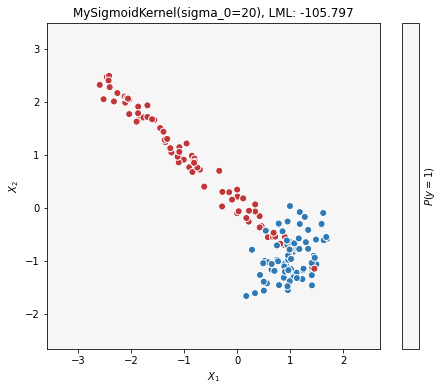

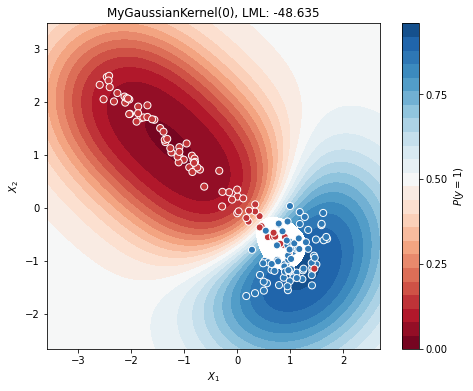

In [63]:
kernels = [
    MySigmoidKernel(), 
    MyGaussianKernel()
#     MyRationalQuadraticKernel(), MyDotProduct(), 
]

gp = [GaussianProcessClassifier(kernel=kernel).fit(X,y) for kernel in kernels]

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(10, 5))
for i, clf in enumerate(gp):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    # Put the result into a color plot
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[:,0], X[:, 1], c=y[:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(aspect="equal",
           xlim=(x_min,x_max), ylim=(y_min,y_max),
           xlabel="$X_1$", ylabel="$X_2$")

    plt.title("%s, LML: %.3f" %
              (str(kernels[i]), clf.log_marginal_likelihood(clf.kernel_.theta)))